# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_8', 'ORACLE.run2_38', 'ORACLE.run2_32', 'ORACLE.run2_50', 'ORACLE.run2_44', 'ORACLE.run2_14', 'ORACLE.run2_20', 'ORACLE.run2_26'}


{'ORACLE.run1_26', 'ORACLE.run1_44', 'ORACLE.run1_38', 'ORACLE.run1_20', 'ORACLE.run1_50', 'ORACLE.run1_8', 'ORACLE.run1_32', 'ORACLE.run1_14'}


tensor([[[ 0.8991,  0.0908, -1.0172,  ...,  0.2816,  1.3714,  0.1453],
         [ 0.3815,  1.1444, -0.4632,  ..., -0.9264, -0.0727, -1.0263]],

        [[ 0.9651,  0.3642, -1.1107,  ..., -0.2458,  1.2018, -0.3551],
         [ 0.0546,  0.9833, -0.1001,  ..., -1.1927, -0.6555, -0.9924]],

        [[ 0.2039,  1.0937, -0.5654,  ..., -1.2235,  0.7322,  0.2225],
         [-0.5561,  0.3986,  0.7044,  ..., -0.5191, -1.0752, -0.8991]],

        ...,

        [[ 0.0504, -1.2349,  0.2331,  ...,  1.1845, -0.3213,  0.0819],
         [ 0.6490, -0.0693, -0.7876,  ...,  0.0000,  1.2665,  0.9892]],

        [[ 0.7104, -0.5484, -0.8973,  ...,  1.0718,  0.8849, -0.3677],
         [ 0.9222,  0.4237, -0.9721,  ..., -0.5297, -0.3739, -1.2400]],

        [[ 0.3635, -0.6768, -0.4199,  ...,  1.0653,  1.1029,  0.7019],
         [ 1.0402,  0.4951, -1.2408,  ..., -0.3133,  0.6768, -1.0402]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 48.7750, train_label_loss: 2.8458, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3162.9081, train_label_loss: 0.6771, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3162.5252, train_label_loss: 0.5692, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3159.3016, train_label_loss: 0.5193, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3146.5063, train_label_loss: 0.9577, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3144.9512, train_label_loss: 0.9163, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3151.1126, train_label_loss: 0.7419, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3150.5772, train_label_loss: 0.5001, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3142.4118, train_label_loss: 0.3980, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3157.6069, train_label_loss: 0.9409, 


epoch: 1, source_val_acc_label: 0.6071, target_val_acc_label: 0.6081, source_val_label_loss: 48.3524, target_val_label_loss: 49.0183, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.6888, train_label_loss: 156.6061, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3166.2751, train_label_loss: 0.6808, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3177.3021, train_label_loss: 0.6316, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3172.1629, train_label_loss: 0.4705, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3161.8564, train_label_loss: 0.6619, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3185.7548, train_label_loss: 0.8703, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3175.8125, train_label_loss: 1.3750, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3168.3172, train_label_loss: 0.8808, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3166.5785, train_label_loss: 1.1705, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3176.3863, train_label_loss: 0.5418, 


epoch: 2, source_val_acc_label: 0.7865, target_val_acc_label: 0.7909, source_val_label_loss: 0.6476, target_val_label_loss: 0.6164, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.7520, train_label_loss: 0.7734, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3164.8843, train_label_loss: 0.3101, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3173.9143, train_label_loss: 0.3726, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3175.4839, train_label_loss: 0.5129, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3161.8289, train_label_loss: 0.3935, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3167.4145, train_label_loss: 0.7447, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3173.0529, train_label_loss: 0.7823, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3167.0881, train_label_loss: 0.7066, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3179.0036, train_label_loss: 0.4206, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3175.1213, train_label_loss: 0.2149, 


epoch: 3, source_val_acc_label: 0.8298, target_val_acc_label: 0.8285, source_val_label_loss: 0.5168, target_val_label_loss: 0.4935, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.7314, train_label_loss: 0.1931, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3153.5212, train_label_loss: 0.2421, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3169.3285, train_label_loss: 0.8855, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3166.7534, train_label_loss: 0.6494, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3168.9719, train_label_loss: 0.2548, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3183.2671, train_label_loss: 0.1362, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3194.2272, train_label_loss: 0.6469, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3165.6942, train_label_loss: 0.5541, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3168.8107, train_label_loss: 0.5136, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3183.4861, train_label_loss: 0.5804, 


epoch: 4, source_val_acc_label: 0.8325, target_val_acc_label: 0.8301, source_val_label_loss: 0.4951, target_val_label_loss: 0.4860, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.7237, train_label_loss: 0.4296, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3165.0627, train_label_loss: 0.1464, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3179.2113, train_label_loss: 0.4646, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3178.2370, train_label_loss: 0.6479, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3165.1125, train_label_loss: 0.4927, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3179.1052, train_label_loss: 1.2078, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3181.0502, train_label_loss: 0.6804, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3179.4215, train_label_loss: 0.2422, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3179.8587, train_label_loss: 0.9963, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3183.2607, train_label_loss: 0.2931, 


epoch: 5, source_val_acc_label: 0.8456, target_val_acc_label: 0.8462, source_val_label_loss: 0.4545, target_val_label_loss: 0.4454, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.7297, train_label_loss: 0.4109, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3158.4573, train_label_loss: 0.5346, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3174.4141, train_label_loss: 0.4280, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3176.0597, train_label_loss: 0.3207, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3174.5210, train_label_loss: 0.9990, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3156.2441, train_label_loss: 0.3882, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3163.4404, train_label_loss: 0.5280, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3138.7256, train_label_loss: 0.2467, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3073.1470, train_label_loss: 0.1404, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2955.9924, train_label_loss: 0.1603, 


epoch: 6, source_val_acc_label: 0.8501, target_val_acc_label: 0.8482, source_val_label_loss: 0.4300, target_val_label_loss: 0.4288, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.5307, train_label_loss: 0.2902, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3069.7426, train_label_loss: 0.7307, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3101.0540, train_label_loss: 0.2811, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3150.8731, train_label_loss: 0.3071, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3130.4238, train_label_loss: 0.3006, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3146.8919, train_label_loss: 0.5276, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3150.5621, train_label_loss: 0.2736, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3148.4665, train_label_loss: 0.3826, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3152.0489, train_label_loss: 0.0939, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3153.7926, train_label_loss: 0.2707, 


epoch: 7, source_val_acc_label: 0.8545, target_val_acc_label: 0.8489, source_val_label_loss: 0.4118, target_val_label_loss: 0.4187, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.6790, train_label_loss: 0.6328, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3119.4493, train_label_loss: 0.5607, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3151.9438, train_label_loss: 0.5605, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3148.2377, train_label_loss: 0.7376, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3134.9640, train_label_loss: 0.0776, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3150.1715, train_label_loss: 0.5099, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3152.4420, train_label_loss: 0.7201, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3142.0593, train_label_loss: 0.3706, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3144.6125, train_label_loss: 0.1496, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3112.3352, train_label_loss: 0.2046, 


epoch: 8, source_val_acc_label: 0.8566, target_val_acc_label: 0.8507, source_val_label_loss: 0.4040, target_val_label_loss: 0.4150, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.7311, train_label_loss: 0.1899, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3162.6366, train_label_loss: 0.2012, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3170.0287, train_label_loss: 0.2135, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3178.4731, train_label_loss: 0.1158, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3165.5780, train_label_loss: 0.0934, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3184.7449, train_label_loss: 0.5014, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3184.2844, train_label_loss: 0.6420, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3178.9192, train_label_loss: 0.0473, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3165.2310, train_label_loss: 0.0428, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3163.9132, train_label_loss: 0.2559, 


epoch: 9, source_val_acc_label: 0.8737, target_val_acc_label: 0.8642, source_val_label_loss: 0.3622, target_val_label_loss: 0.3885, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.7173, train_label_loss: 0.4194, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3154.2678, train_label_loss: 0.1312, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3169.1601, train_label_loss: 0.2464, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3177.7338, train_label_loss: 0.2200, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3169.6189, train_label_loss: 0.2730, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3185.9021, train_label_loss: 0.3079, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3180.7362, train_label_loss: 0.5034, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3180.0327, train_label_loss: 0.4037, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3183.9411, train_label_loss: 0.3020, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3179.4156, train_label_loss: 0.1629, 


epoch: 10, source_val_acc_label: 0.8685, target_val_acc_label: 0.8565, source_val_label_loss: 0.3642, target_val_label_loss: 0.4057, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.7351, train_label_loss: 0.2071, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3155.5339, train_label_loss: 0.2532, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3180.1391, train_label_loss: 0.1772, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3175.3378, train_label_loss: 0.1946, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3171.3083, train_label_loss: 0.3246, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3177.9875, train_label_loss: 0.3174, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3184.1500, train_label_loss: 0.1201, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3162.0806, train_label_loss: 0.1173, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3183.5387, train_label_loss: 0.0280, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3178.0483, train_label_loss: 0.1688, 


epoch: 11, source_val_acc_label: 0.8798, target_val_acc_label: 0.8689, source_val_label_loss: 0.3382, target_val_label_loss: 0.3758, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.7036, train_label_loss: 0.5322, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3152.7222, train_label_loss: 0.1966, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3176.1070, train_label_loss: 0.2361, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3166.4634, train_label_loss: 0.3612, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3154.0159, train_label_loss: 0.2360, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3183.5057, train_label_loss: 0.2024, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3178.6386, train_label_loss: 0.0422, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3170.3135, train_label_loss: 0.3519, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3173.9401, train_label_loss: 0.1955, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3179.1911, train_label_loss: 0.0652, 


epoch: 12, source_val_acc_label: 0.8765, target_val_acc_label: 0.8634, source_val_label_loss: 0.3498, target_val_label_loss: 0.3925, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.7178, train_label_loss: 0.2409, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3162.9925, train_label_loss: 0.2077, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3162.8494, train_label_loss: 0.2559, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3177.2823, train_label_loss: 0.0800, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3167.9952, train_label_loss: 0.3724, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3165.4417, train_label_loss: 0.0562, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3176.6551, train_label_loss: 0.2919, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3168.5735, train_label_loss: 0.1082, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3173.8269, train_label_loss: 0.1355, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3171.1122, train_label_loss: 0.4321, 


epoch: 13, source_val_acc_label: 0.8854, target_val_acc_label: 0.8750, source_val_label_loss: 0.3233, target_val_label_loss: 0.3607, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.7321, train_label_loss: 0.2092, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3155.5138, train_label_loss: 0.1962, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3174.6243, train_label_loss: 0.2363, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3150.7277, train_label_loss: 0.1682, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3167.0314, train_label_loss: 0.3213, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3182.6196, train_label_loss: 0.2635, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3174.2255, train_label_loss: 0.2107, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3175.8981, train_label_loss: 0.1476, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3183.2079, train_label_loss: 0.0435, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3173.6286, train_label_loss: 0.2335, 


epoch: 14, source_val_acc_label: 0.8905, target_val_acc_label: 0.8790, source_val_label_loss: 0.3071, target_val_label_loss: 0.3548, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.7323, train_label_loss: 0.4971, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3168.4081, train_label_loss: 0.3692, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3174.2561, train_label_loss: 0.3387, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3177.5342, train_label_loss: 0.1879, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3167.5342, train_label_loss: 0.2215, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3161.2981, train_label_loss: 0.0451, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3172.5280, train_label_loss: 0.3569, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3160.8867, train_label_loss: 0.3004, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3170.3230, train_label_loss: 0.0655, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3164.4347, train_label_loss: 0.1727, 


epoch: 15, source_val_acc_label: 0.8928, target_val_acc_label: 0.8798, source_val_label_loss: 0.3073, target_val_label_loss: 0.3465, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.7186, train_label_loss: 0.1954, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3163.2020, train_label_loss: 0.1076, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3170.6863, train_label_loss: 0.0984, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3178.4399, train_label_loss: 0.2992, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3152.5720, train_label_loss: 0.2995, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3167.2179, train_label_loss: 0.1953, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3174.0012, train_label_loss: 0.5304, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3170.9907, train_label_loss: 0.1606, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3169.9329, train_label_loss: 0.4941, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3178.2465, train_label_loss: 0.0781, 


epoch: 16, source_val_acc_label: 0.8827, target_val_acc_label: 0.8710, source_val_label_loss: 0.3269, target_val_label_loss: 0.3721, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.7375, train_label_loss: 0.2757, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3170.3636, train_label_loss: 0.1374, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3171.0874, train_label_loss: 0.1096, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3182.4518, train_label_loss: 0.6823, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3169.3272, train_label_loss: 0.1438, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3181.6878, train_label_loss: 0.3851, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3173.4979, train_label_loss: 0.1708, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3169.3003, train_label_loss: 0.0704, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3185.3891, train_label_loss: 0.4000, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3188.7402, train_label_loss: 0.5669, 


epoch: 17, source_val_acc_label: 0.8924, target_val_acc_label: 0.8822, source_val_label_loss: 0.3113, target_val_label_loss: 0.3550, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 4.7394, train_label_loss: 0.3482, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 3151.2446, train_label_loss: 0.0755, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3176.1463, train_label_loss: 0.1349, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 3182.6250, train_label_loss: 0.3882, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 3173.5697, train_label_loss: 0.2488, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3185.1761, train_label_loss: 0.1652, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3170.5007, train_label_loss: 0.1530, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 3167.7140, train_label_loss: 0.3022, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3172.0479, train_label_loss: 0.1549, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3173.2345, train_label_loss: 0.2708, 


epoch: 18, source_val_acc_label: 0.8959, target_val_acc_label: 0.8827, source_val_label_loss: 0.2989, target_val_label_loss: 0.3505, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 4.7468, train_label_loss: 0.2155, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3155.9646, train_label_loss: 0.2793, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 3175.9011, train_label_loss: 0.2067, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 3172.3181, train_label_loss: 0.4463, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 3187.4659, train_label_loss: 0.1796, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 3179.5667, train_label_loss: 0.0881, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 3178.3154, train_label_loss: 0.3561, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3175.8141, train_label_loss: 0.2841, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3174.8965, train_label_loss: 0.2184, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3173.8536, train_label_loss: 0.2166, 


epoch: 19, source_val_acc_label: 0.8910, target_val_acc_label: 0.8731, source_val_label_loss: 0.3064, target_val_label_loss: 0.3719, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

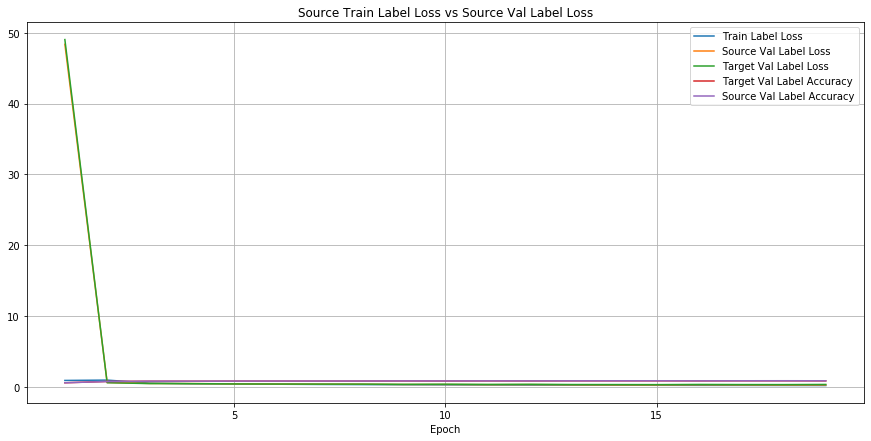

In [25]:
ax = get_loss_curve(experiment)
plt.show()

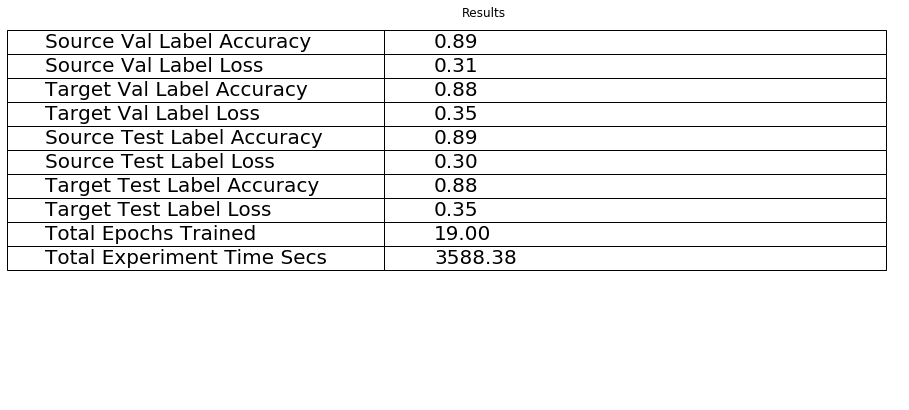

In [26]:
get_results_table(experiment)

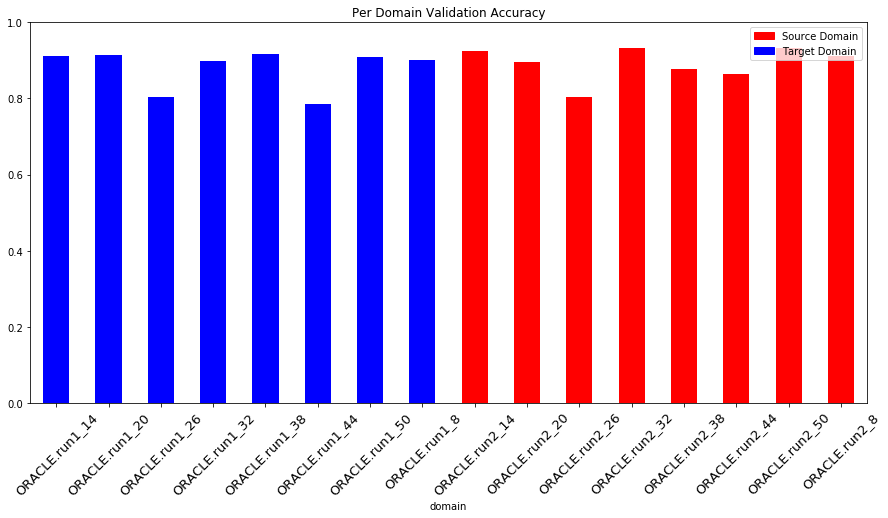

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.89248046875 Target Test Label Accuracy: 0.8823893229166667
Source Val Label Accuracy: 0.8928385416666667 Target Val Label Accuracy: 0.8797526041666667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1_oracle.run1-oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480